<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Изменение-баланса-классов" data-toc-modified-id="Изменение-баланса-классов-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Изменение баланса классов</a></span><ul class="toc-item"><li><span><a href="#Изменение-весов-классов" data-toc-modified-id="Изменение-весов-классов-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Изменение весов классов</a></span></li><li><span><a href="#Ресемплирование-с-уменьшением-класса-0" data-toc-modified-id="Ресемплирование-с-уменьшением-класса-0-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Ресемплирование с уменьшением класса 0</a></span></li></ul></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Классификатор-LogisticRegression" data-toc-modified-id="Классификатор-LogisticRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Классификатор LogisticRegression</a></span></li><li><span><a href="#Классификатор-DecisionTreeClassifier" data-toc-modified-id="Классификатор-DecisionTreeClassifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Классификатор DecisionTreeClassifier</a></span></li><li><span><a href="#Классификатор-CatBoostClassifier" data-toc-modified-id="Классификатор-CatBoostClassifier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Классификатор CatBoostClassifier</a></span></li><li><span><a href="#Классификатор-SGDClassifier" data-toc-modified-id="Классификатор-SGDClassifier-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Классификатор SGDClassifier</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import spacy
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')

## Подготовка

In [2]:
toxic_comments = pd.read_csv('/datasets/toxic_comments.csv')
toxic_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [3]:
toxic_comments.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
toxic_comments.duplicated().sum()

0

Явных дубликатов не выявлено, как и пропусков.

In [5]:
display(toxic_comments['toxic'].value_counts())
class_ratio = toxic_comments['toxic'].value_counts()[0] / toxic_comments['toxic'].value_counts()[1]
class_ratio

0    143106
1     16186
Name: toxic, dtype: int64

8.841344371679229

Классы несбалансированы. Отношение 1:8.83. Проведем поиск лучшего способа балансировки и сравним качество.

- Изменение весов в модели обучения
- Ресемплирование с уменьшением класса 0

Ресемплирование с увеличением класса 1 не будем использовать из-за громоздкого набора данных.

Подготовим признаки и целевой признак перед обучением.

In [6]:
nlp = spacy.load('en_core_web_sm')

def lemmatize_text(text):
    text = re.sub('[^A-Za-z]+', ' ', str(text)) #remove special character and intergers
    doc = nlp(text)
    cleared_text=[]
    for token in doc:
        if token.is_stop: #Remove Stopwords
            pass
        else:
            cleared_text.append(token.lemma_.lower()) 
    return " ".join(cleared_text)

toxic_comments['lemm_text'] = toxic_comments['text'].apply(lemmatize_text)

toxic_comments = toxic_comments.drop(['text'], axis=1)

In [7]:
sentence1 = "The striped bats are hanging on their feet for best"
sentence2 = "you should be ashamed of yourself went worked"
df_my = pd.DataFrame([sentence1, sentence2], columns = ['text'])
print(df_my)


print(df_my['text'].apply(lemmatize_text))

                                                text
0  The striped bats are hanging on their feet for...
1      you should be ashamed of yourself went worked
0    stripe bat hang foot good
1              ashamed go work
Name: text, dtype: object


Разобьем выборку по отношению 80/20. Уменьшим количество кроссвалидаций до 3 из-за размера выборки.

In [8]:
target = toxic_comments['toxic']
features = toxic_comments.drop(['toxic'], axis=1)

features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                              target, 
                                                                              test_size=0.2, 
                                                                              random_state=12082020)

#features_valid, features_test, target_valid, target_test = train_test_split(features_valid, 
                                                                              #target_valid, 
                                                                              #test_size=0.5, 
                                                                              #random_state=12082020)

count_tf_idf = TfidfVectorizer()

features_train = count_tf_idf.fit_transform(features_train['lemm_text'])
#features_valid = count_tf_idf.fit_transform(features_valid['lemm_text'])
features_test = count_tf_idf.transform(features_test['lemm_text'])
print(features_train.shape)
#print(features_valid.shape)
print(features_test.shape)
cv_counts = 5

(127433, 137456)
(31859, 137456)


In [9]:
classificator = LogisticRegression()
train_f1 = cross_val_score(classificator, 
                      features_train, 
                      target_train, 
                      cv=cv_counts, 
                      scoring='f1').mean()
print('F1 на CV', train_f1)

F1 на CV 0.7222025841805128


### Изменение баланса классов

#### Изменение весов классов

In [10]:
dict_classes={0:1, 1:class_ratio}
classificator = LogisticRegression(class_weight=dict_classes)
train_f1_ballanced = cross_val_score(classificator, 
                                    features_train, 
                                    target_train, 
                                    cv=cv_counts, 
                                    scoring='f1').mean()
print('F1 на CV с балансированными классами', train_f1_ballanced)

F1 на CV с балансированными классами 0.7625253322425258


In [11]:
classificator = LogisticRegression(class_weight='balanced')
train_f1_balanced = cross_val_score(classificator, 
                                    features_train, 
                                    target_train, 
                                    cv=cv_counts, 
                                    scoring='f1').mean()
print('F1 на CV с балансированными классами', train_f1_ballanced)

F1 на CV с балансированными классами 0.7625253322425258


Как видно на обучающей выборке F1-мера увеличилась. Встроенный метод повторяет значение F1.

#### Ресемплирование с уменьшением класса 0

Сделаем количество записей с классом 0 таким же, как и количество записей с классом 1.

Прирост F1-меры ощутимый.

Построим ROC-AUC графики и просмотрим таблицу результатов баллансирования.

Выберем метод балансировки по весу. Удалим ненужные переменные.

**Выводы по разделу:** 

В ходе преподготовки были получены признаки для обучения и разделена выборка на обучающую, валидационную и тестовую.

На тестировании оптимальными показателями F1 и AUC-ROC обладает классификатор, где учтен вес классов. В обучении мы будем использовать именно этот метод балансирования.

## Обучение

Для обучения выберем следующие модели:

- LogisticRegression
- DecisionTreeClassifier
- CatBoostClassifier
- SGDClassifier

### Классификатор LogisticRegression

In [18]:
classificator = LogisticRegression()
hyperparams = [{'solver':['newton-cg', 'lbfgs', 'liblinear'],
                'C':[0.1, 1, 10],
                'class_weight':[dict_classes]}]


print('# Tuning hyper-parameters for f1_score')
print()
clf = GridSearchCV(classificator, hyperparams, scoring='f1',cv=cv_counts)
clf.fit(features_train, target_train)
print("Best parameters set found on development set:")
print()
LR_best_params = clf.best_params_
print(LR_best_params)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))
print()

cv_f1_LR = max(means)

# Tuning hyper-parameters for f1_score

Best parameters set found on development set:

{'C': 10, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver': 'lbfgs'}

Grid scores on development set:

0.727692 for {'C': 0.1, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver': 'newton-cg'}
0.727692 for {'C': 0.1, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver': 'lbfgs'}
0.727770 for {'C': 0.1, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver': 'liblinear'}
0.762540 for {'C': 1, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver': 'newton-cg'}
0.762525 for {'C': 1, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver': 'lbfgs'}
0.762540 for {'C': 1, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver': 'liblinear'}
0.766720 for {'C': 10, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver': 'newton-cg'}
0.768951 for {'C': 10, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver': 'lbfgs'}
0.766811 for {'C': 10, 'class_weight': {0: 1, 1: 8.841344371679229}, 'solver': '

In [19]:
#classificator = LogisticRegression()
#classificator.set_params(**LR_best_params)
#classificator.fit(features_train, target_train)
#target_predict = classificator.predict(features_valid)
#valid_f1_LR = f1_score(target_valid, target_predict)
print('F1 на cv', cv_f1_LR)
#print('F1 на валидации', valid_f1_LR)

F1 на cv 0.7689514701114404


### Классификатор DecisionTreeClassifier

In [20]:
classificator = DecisionTreeClassifier()
hyperparams = [{'max_depth':[x for x in range(30,51,2)],
                'random_state':[12082020],
                'class_weight':[dict_classes]}]


print('# Tuning hyper-parameters for f1_score')
print()
clf = GridSearchCV(classificator, hyperparams, scoring='f1',cv=cv_counts)
clf.fit(features_train, target_train)
print("Best parameters set found on development set:")
print()
DTC_best_params = clf.best_params_
print(DTC_best_params)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))
print()

cv_f1_DTC = max(means)

# Tuning hyper-parameters for f1_score

Best parameters set found on development set:

{'class_weight': {0: 1, 1: 8.841344371679229}, 'max_depth': 44, 'random_state': 12082020}

Grid scores on development set:

0.660683 for {'class_weight': {0: 1, 1: 8.841344371679229}, 'max_depth': 30, 'random_state': 12082020}
0.661586 for {'class_weight': {0: 1, 1: 8.841344371679229}, 'max_depth': 32, 'random_state': 12082020}
0.665564 for {'class_weight': {0: 1, 1: 8.841344371679229}, 'max_depth': 34, 'random_state': 12082020}
0.666658 for {'class_weight': {0: 1, 1: 8.841344371679229}, 'max_depth': 36, 'random_state': 12082020}
0.671529 for {'class_weight': {0: 1, 1: 8.841344371679229}, 'max_depth': 38, 'random_state': 12082020}
0.674453 for {'class_weight': {0: 1, 1: 8.841344371679229}, 'max_depth': 40, 'random_state': 12082020}
0.676246 for {'class_weight': {0: 1, 1: 8.841344371679229}, 'max_depth': 42, 'random_state': 12082020}
0.678735 for {'class_weight': {0: 1, 1: 8.841344371679229}, 'max_dep

In [21]:
#classificator = DecisionTreeClassifier()
#classificator.set_params(**DTC_best_params)
#classificator.fit(features_train, target_train)
#target_predict = classificator.predict(features_valid)
#valid_f1_DTC = f1_score(target_valid, target_predict)
print('F1 на cv', cv_f1_DTC)
#print('F1 на валидации', valid_f1_DTC)

F1 на cv 0.6787346175878277


### Классификатор CatBoostClassifier

In [22]:
classificator = CatBoostClassifier(verbose=False, iterations=200)
classificator.fit(features_train, target_train)
#target_predict = classificator.predict(features_valid)
cv_f1_CBC = cross_val_score(classificator,
                            features_train,
                            target_train, 
                            cv=cv_counts,
                            scoring='f1').mean()
#valid_f1_CBC = f1_score(target_valid, target_predict)
print('F1 на cv', cv_f1_CBC)
#print('F1 на валидации', valid_f1_CBC)

F1 на cv 0.7437599614579807


### Классификатор SGDClassifier

In [23]:
classificator = SGDClassifier()
hyperparams = [{'loss':['hinge', 'log', 'modified_huber'],
                'learning_rate':['constant', 'optimal', 'invscaling', 'adaptive'],
                'eta0':[0.01, 0.05, 0.1, 0.2, 0.3, 0.5],
                'random_state':[12082020],
                'class_weight':[dict_classes]}]


print('# Tuning hyper-parameters for f1_score')
print()
clf = GridSearchCV(classificator, hyperparams, scoring='f1',cv=cv_counts)
clf.fit(features_train, target_train)
print("Best parameters set found on development set:")
print()
SGDC_best_params = clf.best_params_
print(SGDC_best_params)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))
print()

cv_f1_SGDC = max(means)

# Tuning hyper-parameters for f1_score

Best parameters set found on development set:

{'class_weight': {0: 1, 1: 8.841344371679229}, 'eta0': 0.1, 'learning_rate': 'adaptive', 'loss': 'modified_huber', 'random_state': 12082020}

Grid scores on development set:

0.750348 for {'class_weight': {0: 1, 1: 8.841344371679229}, 'eta0': 0.01, 'learning_rate': 'constant', 'loss': 'hinge', 'random_state': 12082020}
0.724423 for {'class_weight': {0: 1, 1: 8.841344371679229}, 'eta0': 0.01, 'learning_rate': 'constant', 'loss': 'log', 'random_state': 12082020}
0.757369 for {'class_weight': {0: 1, 1: 8.841344371679229}, 'eta0': 0.01, 'learning_rate': 'constant', 'loss': 'modified_huber', 'random_state': 12082020}
0.748693 for {'class_weight': {0: 1, 1: 8.841344371679229}, 'eta0': 0.01, 'learning_rate': 'optimal', 'loss': 'hinge', 'random_state': 12082020}
0.725499 for {'class_weight': {0: 1, 1: 8.841344371679229}, 'eta0': 0.01, 'learning_rate': 'optimal', 'loss': 'log', 'random_state': 12082020}
0.758

In [24]:
#classificator = SGDClassifier()
#classificator.set_params(**SGDC_best_params)
#classificator.fit(features_train, target_train)
#arget_predict = classificator.predict(features_valid)
#valid_f1_SGDC = f1_score(target_valid, target_predict)
print('F1 на cv', cv_f1_SGDC)
#print('F1 на валидации', valid_f1_SGDC)

F1 на cv 0.7637030296787671


Выведем таблицу валидации лучших моделей.

In [25]:
index = ['LogisticRegression',
         'DecisionTreeClassifier',
         'CatBoostClassifier',
         'SGDClassifier']
data = {'F1 на CV':[cv_f1_LR,
                    cv_f1_DTC,
                    cv_f1_CBC,
                    cv_f1_SGDC]}
        #'F1 на валидации':[valid_f1_LR,
                          # valid_f1_DTC,
                           #valid_f1_CBC,
                           #valid_f1_SGDC]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['Выполнение задачи'] = scores_data['F1 на CV'] > 0.75
scores_data

,F1 на CV,Выполнение задачи
LogisticRegression,0.768951,True
DecisionTreeClassifier,0.678735,False
CatBoostClassifier,0.743760,False
SGDClassifier,0.763703,True


**Выводы по разделу:** 

К тестовому набору данных перейдёт LogisticRegression.

## Выводы

Проведем получение F1-меры, precision, recall, accuracy и roc_auc. Так же построим графики.

Метрики LogisticRegression
ROC AUC: 0.9628145127417002
F1: 0.7533969355305002
Precision: 0.7035637149028078
Recall: 0.8108276291225887
Accuracy: 0.9464515521516683



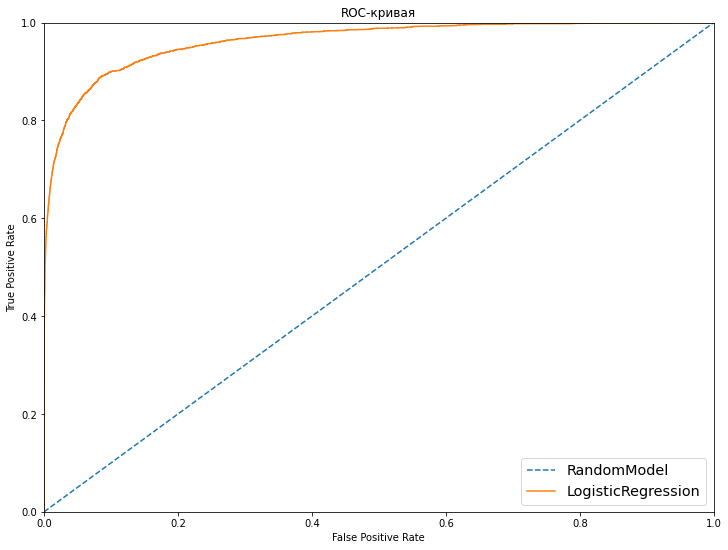

In [26]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')


classificator = LogisticRegression()
classificator.set_params(**LR_best_params)
classificator.fit(features_train, target_train)
probabilities_test = classificator.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
predict_test = classificator.predict(features_test)
plt.plot(fpr, tpr, label='LogisticRegression')
print('Метрики LogisticRegression')
print('ROC AUC:', roc_auc_score(target_test, probabilities_one_test))
print('F1:', f1_score(target_test, predict_test))
print('Precision:', precision_score(target_test, predict_test))
print('Recall:', recall_score(target_test, predict_test))
print('Accuracy:', accuracy_score(target_test, predict_test))
print()


plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

В ходе работы над проектом было сделано:

- Подготовленны данные обучения на моделях.
- Выбран способ баланса классов и поделены данные на обучающую, валидационную и тестовою выборку.
- Обучены модели и выбраны лучшие из них на валидационной выборке.
- Показаны параметры качества моделей.

Исходные данные обладают большим количеством признаков. Созданных столбцов больше, чем записей данных. Так как TF-IDF превращают текст в численные значения, лучшими моделями стали LogisticRegression и SGDClassifier. CatBoostClassifier может показать себя очень хорошо при долгом обучении на данных. В ходе тестов данный классификатор мог обучатся до 5 часов.

На тестовой выбоке по метрике F1 лучше всего себя показал LogisticRegression всего на 0.09. Данная модель обладает большими показателями Precision и Accuracy. Это говорит нам, что токсичные комментарии находятся лучше.

SGDClassifier показал себя лучше в ROC AUC и Recall метриках. Модель способна обработать больше записей.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны